In [1]:
DATA_PATH = "T4 Dataset"
BATCH_SIZE = 32
EPOCHS = 10
MODELS_TO_RUN = ["UNET_SGD", "UNET_ADAM", "UNET++_ADAM", "UNET++_SGD"]
# MODELS_TO_RUN = ["UNET_ADAM"]

In [2]:
import tensorflow as tf
import numpy as np
import keras.backend as K
import os
from keras_unet_collection import models
import matplotlib.pyplot as plt
import json

In [3]:
def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    up = 2.0 * intersection + smooth
    down = K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    return up / down


def bce_dice_loss(y_true, y_pred):
    celoss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return celoss + (1 - dice_coef(y_true, y_pred))


# split eval_datagen into validation and test returning flow iterators
def split_eval_datagen(eval_datagen, total_batches):
    # go through eval_datagen and split into validation and test
    # 50% validation, 50% test
    validation_data = []
    test_data = []

    for batch_index, data in enumerate(eval_datagen):
        if batch_index < total_batches / 2:
            validation_data.append(data)
        else:
            test_data.append(data)

    return validation_data, test_data

In [4]:
def create_datagen(datagen, path, subset):
    return datagen.flow_from_directory(path, target_size=(128, 128), color_mode="grayscale", class_mode=None, batch_size=BATCH_SIZE, shuffle=True, seed=42, subset=subset)

In [5]:
datagen_kwargs = dict(rescale=1.0 / 255, validation_split=0.2)
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

images_path = os.path.normpath(os.path.join(DATA_PATH, "Images"))
masks_path = os.path.normpath(os.path.join(DATA_PATH, "Masks"))

train_image_generator = create_datagen(image_datagen, images_path, "training")
train_mask_generator = create_datagen(mask_datagen, masks_path, "training")

eval_image_generator = create_datagen(image_datagen, images_path, "validation")
eval_mask_generator = create_datagen(mask_datagen, masks_path, "validation")

train_datagen = zip(train_image_generator, train_mask_generator)
eval_datagen = zip(eval_image_generator, eval_mask_generator)

Found 542 images belonging to 1 classes.
Found 542 images belonging to 1 classes.
Found 135 images belonging to 1 classes.
Found 135 images belonging to 1 classes.


In [6]:
# display some sample images
def display_sample(datagen):
    x, y = next(datagen)
    print(x.shape, y.shape)
    for i in range(0, 3):
        image = x[i]
        mask = y[i]
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.squeeze(image), cmap="gray")
        plt.title("Image")
        plt.subplot(1, 2, 2)
        plt.imshow(np.squeeze(mask), cmap="gray")
        plt.title("Mask")
        plt.show()

(32, 128, 128, 1) (32, 128, 128, 1)


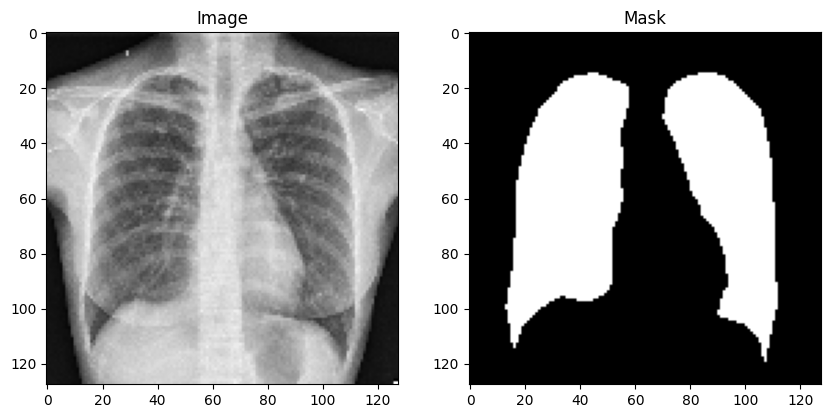

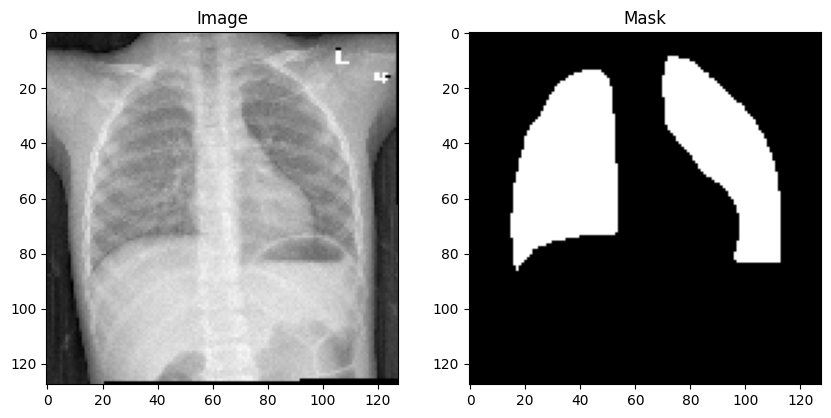

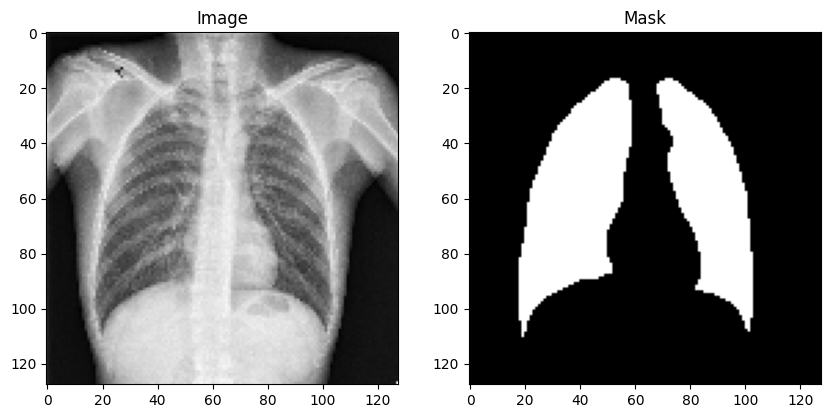

(32, 128, 128, 1) (32, 128, 128, 1)


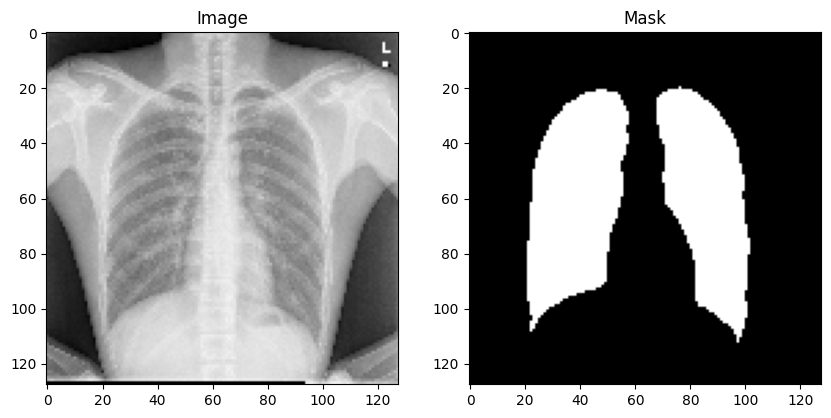

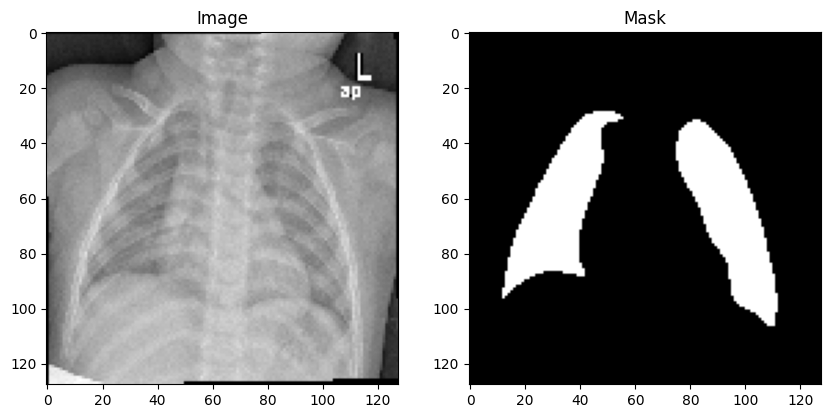

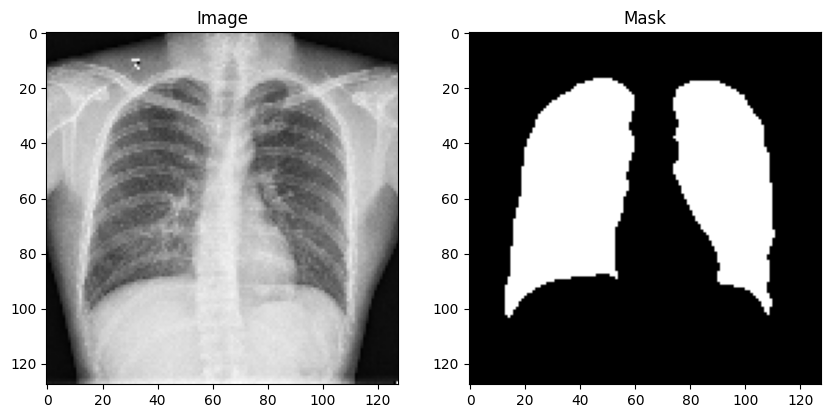

In [7]:
display_sample(train_datagen)
display_sample(eval_datagen)

In [8]:
train_samples = train_image_generator.samples
eval_samples = eval_image_generator.samples
print("Train samples:", train_samples)
print("Validation samples:", eval_samples)

# Calculate steps per epoch and validation steps
steps_per_epoch = train_samples // BATCH_SIZE
validation_steps = eval_samples // BATCH_SIZE
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Train samples: 542
Validation samples: 135
Steps per epoch: 16
Validation steps: 4


In [9]:
def build_and_train_model(name, model, optimizer):
    model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_coef])

    if os.path.exists(f"{name}.h5"):
        model.load_weights(f"{name}.h5")
        history = json.load(open(f"{name}_history.json", "r"))
    else:
        history = model.fit(train_datagen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=eval_datagen, validation_steps=validation_steps)
        json.dump(history.history, open(f"{name}_history.json", "w"))
        history = history.history
        model.save_weights(f"{name}.h5")
    return model, history

In [10]:
if "UNET_ADAM" in MODELS_TO_RUN:
    unet_adam = models.unet_2d(
        input_size=(128, 128, 1),
        filter_num=[64, 128, 256, 512],
        n_labels=1,
        output_activation="Sigmoid"
    )
    unet_adam, unet_history_adam = build_and_train_model("unet_adam", unet_adam, tf.keras.optimizers.legacy.Adam())

2023-11-14 20:36:46.395376: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-14 20:36:46.395404: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-14 20:36:46.395413: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-14 20:36:46.395447: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-14 20:36:46.395463: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-11-14 20:36:51.916457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 88s 6s/step - loss: 1.3540 - dice_coef: 0.3023 - val_loss: 1.1470 - val_dice_coef: 0.3285
Epoch 2/10
16/16 [==============================] - 79s 5s/step - loss: 1.1323 - dice_coef: 0.3658 - val_loss: 1.0209 - val_dice_coef: 0.3643
Epoch 3/10
16/16 [==============================] - 75s 5s/step - loss: 0.9480 - dice_coef: 0.4472 - val_loss: 0.9477 - val_dice_coef: 0.4536
Epoch 4/10
16/16 [==============================] - 75s 5s/step - loss: 0.8294 - dice_coef: 0.5662 - val_loss: 0.5722 - val_dice_coef: 0.6872
Epoch 5/10
16/16 [==============================] - 75s 5s/step - loss: 0.5370 - dice_coef: 0.7313 - val_loss: 0.4494 - val_dice_coef: 0.7679
Epoch 6/10
16/16 [==============================] - 74s 5s/step - loss: 0.3978 - dice_coef: 0.8091 - val_loss: 0.3744 - val_dice_coef: 0.8151
Epoch 7/10
16/16 [==============================] - 137s 9s/step - loss: 0.2826 - dice_coef: 0.8692 - val_loss: 0.2572 - val_dice_coef: 0.8694
Epoch 8/10
16/16

In [11]:
if "UNET_SGD" in MODELS_TO_RUN:
    unet_sgd = models.unet_2d(input_size=(128, 128, 1), filter_num=[64, 128, 256, 512], n_labels=1, output_activation="Sigmoid")
    unet_sgd, unet_history_sgd = build_and_train_model("unet_sgd", unet_sgd, tf.keras.optimizers.legacy.SGD())

Epoch 1/10
16/16 [==============================] - 87s 6s/step - loss: 1.3443 - dice_coef: 0.3351 - val_loss: 1.3486 - val_dice_coef: 0.3009
Epoch 2/10
16/16 [==============================] - 79s 5s/step - loss: 1.3183 - dice_coef: 0.3315 - val_loss: 1.3252 - val_dice_coef: 0.3044
Epoch 3/10
16/16 [==============================] - 74s 5s/step - loss: 1.3021 - dice_coef: 0.3220 - val_loss: 1.3066 - val_dice_coef: 0.2905
Epoch 4/10
16/16 [==============================] - 76s 5s/step - loss: 1.2863 - dice_coef: 0.3177 - val_loss: 1.2947 - val_dice_coef: 0.2914
Epoch 5/10
16/16 [==============================] - 74s 5s/step - loss: 1.2779 - dice_coef: 0.3102 - val_loss: 1.2876 - val_dice_coef: 0.2813
Epoch 6/10
16/16 [==============================] - 75s 5s/step - loss: 1.2736 - dice_coef: 0.3053 - val_loss: 1.2866 - val_dice_coef: 0.2806
Epoch 7/10
16/16 [==============================] - 76s 5s/step - loss: 1.2701 - dice_coef: 0.3044 - val_loss: 1.2847 - val_dice_coef: 0.2740
Epoch 

In [12]:
if "UNET++_ADAM" in MODELS_TO_RUN:
    unet_plus_adam = models.unet_plus_2d(input_size=(128, 128, 1), filter_num=[64, 128, 256, 512], n_labels=1, output_activation="Sigmoid")
    unet_plus_adam, unet_plus_history_adam = build_and_train_model("unet_plus_adam", unet_plus_adam, tf.keras.optimizers.legacy.Adam())

Epoch 1/10
16/16 [==============================] - 88s 6s/step - loss: 2.1021 - dice_coef: 0.2984 - val_loss: 1.3060 - val_dice_coef: 0.2660
Epoch 2/10
16/16 [==============================] - 79s 5s/step - loss: 1.2990 - dice_coef: 0.2961 - val_loss: 1.1685 - val_dice_coef: 0.3283
Epoch 3/10
16/16 [==============================] - 78s 5s/step - loss: 1.5296 - dice_coef: 0.3050 - val_loss: 1.3058 - val_dice_coef: 0.2777
Epoch 4/10
16/16 [==============================] - 80s 5s/step - loss: 1.2264 - dice_coef: 0.3261 - val_loss: 1.0568 - val_dice_coef: 0.3796
Epoch 5/10
16/16 [==============================] - 78s 5s/step - loss: 1.0653 - dice_coef: 0.4079 - val_loss: 0.9777 - val_dice_coef: 0.4206
Epoch 6/10
16/16 [==============================] - 83s 5s/step - loss: 0.9353 - dice_coef: 0.5205 - val_loss: 0.9182 - val_dice_coef: 0.4495
Epoch 7/10
16/16 [==============================] - 76s 5s/step - loss: 0.8834 - dice_coef: 0.4917 - val_loss: 0.8485 - val_dice_coef: 0.4904
Epoch 

In [13]:
if "UNET++_SGD" in MODELS_TO_RUN:
    unet_plus_sgd = models.unet_plus_2d(input_size=(128, 128, 1), filter_num=[64, 128, 256, 512], n_labels=1, output_activation="Sigmoid")
    unet_plus_sgd, unet_plus_history_sgd = build_and_train_model("unet_plus_sgd", unet_plus_sgd, tf.keras.optimizers.legacy.SGD())

Epoch 1/10
16/16 [==============================] - 89s 6s/step - loss: 1.3473 - dice_coef: 0.3376 - val_loss: 1.3633 - val_dice_coef: 0.3120
Epoch 2/10
16/16 [==============================] - 79s 5s/step - loss: 1.3362 - dice_coef: 0.3321 - val_loss: 1.3481 - val_dice_coef: 0.3040
Epoch 3/10
16/16 [==============================] - 75s 5s/step - loss: 1.3249 - dice_coef: 0.3298 - val_loss: 1.3360 - val_dice_coef: 0.3047
Epoch 4/10
16/16 [==============================] - 75s 5s/step - loss: 1.3189 - dice_coef: 0.3229 - val_loss: 1.3265 - val_dice_coef: 0.3035
Epoch 5/10
16/16 [==============================] - 77s 5s/step - loss: 1.3107 - dice_coef: 0.3219 - val_loss: 1.3230 - val_dice_coef: 0.2940
Epoch 6/10
16/16 [==============================] - 76s 5s/step - loss: 1.3069 - dice_coef: 0.3166 - val_loss: 1.3129 - val_dice_coef: 0.2990
Epoch 7/10
16/16 [==============================] - 74s 5s/step - loss: 1.3033 - dice_coef: 0.3126 - val_loss: 1.3101 - val_dice_coef: 0.2904
Epoch 

# Evaluacion de los modelos

## UNet

In [14]:
# Evaluar el modelo UNet Adam
if "UNET_ADAM" in MODELS_TO_RUN:
    eval_unet_adam = unet_adam.evaluate(eval_datagen, steps=validation_steps)
    print(f"UNet Adam Evaluation - Loss: {eval_unet_adam[0]}, Dice Coef: {eval_unet_adam[1]}")

# Evaluar el modelo UNet SGD
if "UNET_SGD" in MODELS_TO_RUN:
    eval_unet_sgd = unet_sgd.evaluate(eval_datagen, steps=validation_steps)
    print(f"UNet SGD Evaluation - Loss: {eval_unet_sgd[0]}, Dice Coef: {eval_unet_sgd[1]}")

4/4 [==============================] - 9s 3s/step - loss: 0.1722 - dice_coef: 0.9137
UNet Adam Evaluation - Loss: 0.17218001186847687, Dice Coef: 0.9137259721755981
4/4 [==============================] - 9s 3s/step - loss: 1.2792 - dice_coef: 0.2716
UNet SGD Evaluation - Loss: 1.2792326211929321, Dice Coef: 0.27156782150268555


## UNet++

In [15]:
# Evaluar el modelo UNet++ Adam
if "UNET++_ADAM" in MODELS_TO_RUN:
    eval_unet_plus_adam = unet_plus_adam.evaluate(eval_datagen, steps=validation_steps)
    print(f"UNet++ Adam Evaluation - Loss: {eval_unet_plus_adam[0]}, Dice Coef: {eval_unet_plus_adam[1]}")

# Evaluar el modelo UNet++ SGD
if "UNET++_SGD" in MODELS_TO_RUN:
    eval_unet_plus_sgd = unet_plus_sgd.evaluate(eval_datagen, steps=validation_steps)
    print(f"UNet++ SGD Evaluation - Loss: {eval_unet_plus_sgd[0]}, Dice Coef: {eval_unet_plus_sgd[1]}")

4/4 [==============================] - 8s 3s/step - loss: 0.5552 - dice_coef: 0.7445
UNet++ Adam Evaluation - Loss: 0.5551728010177612, Dice Coef: 0.7444910407066345
4/4 [==============================] - 8s 3s/step - loss: 1.3004 - dice_coef: 0.2862
UNet++ SGD Evaluation - Loss: 1.3003888130187988, Dice Coef: 0.2862011194229126


# Graficos de Loss y Dice por EPOCH

In [16]:
def graph_loss_dice(name, history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history["loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["dice_coef"], label="Training Dice Coef")
    plt.plot(history["val_dice_coef"], label="Validation Dice Coef")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coef")
    plt.legend()

    plt.suptitle(f"{name} Training Metrics")
    plt.show()

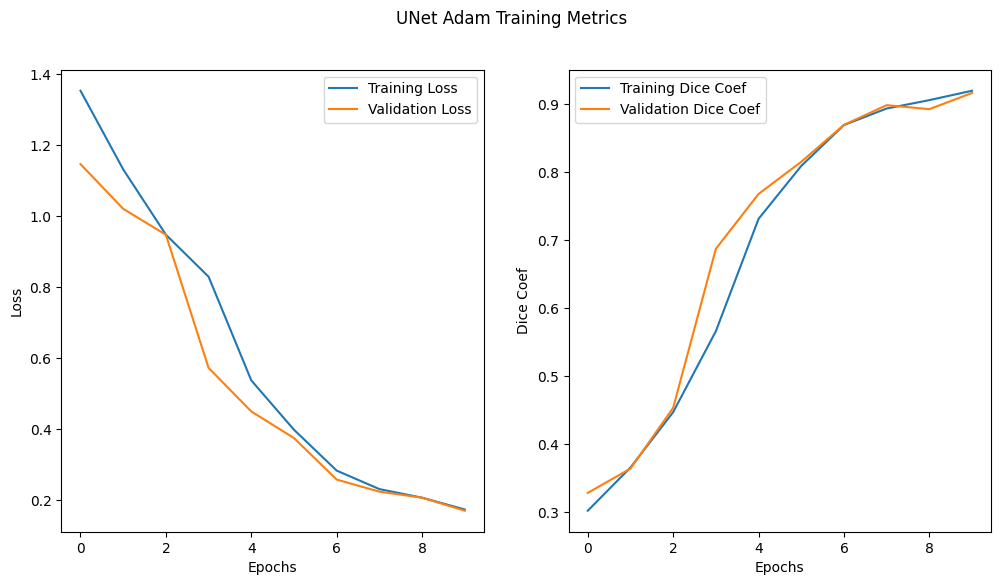

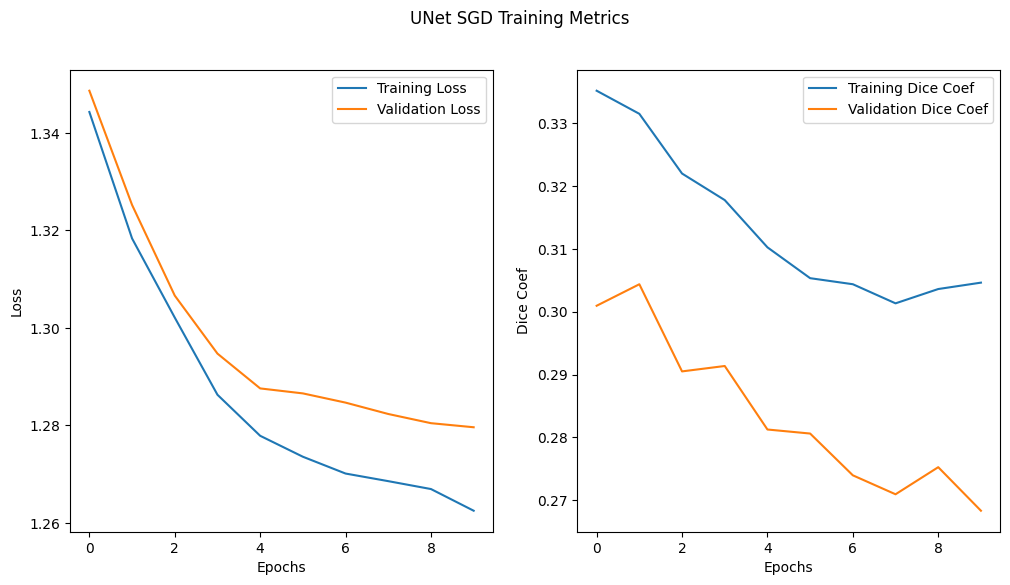

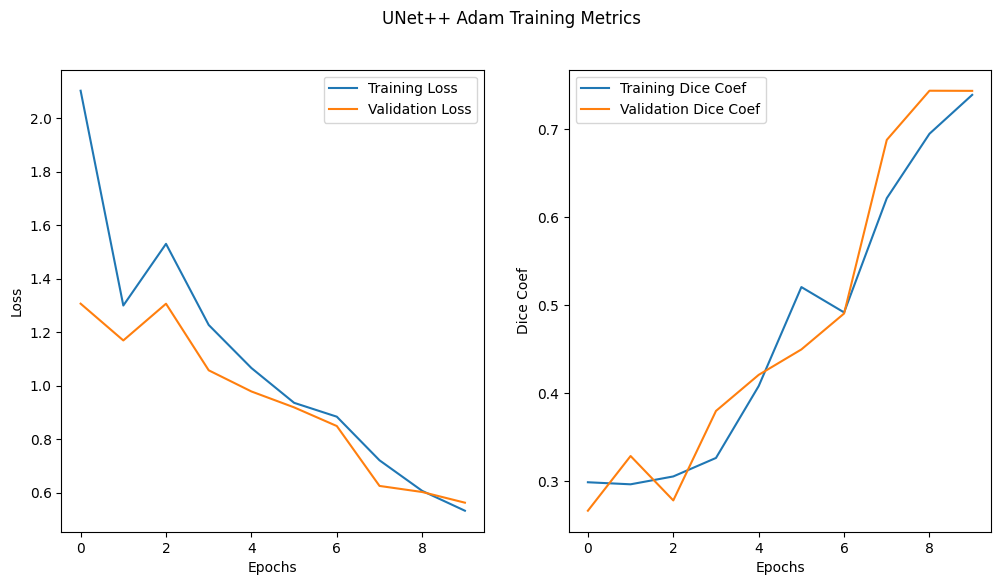

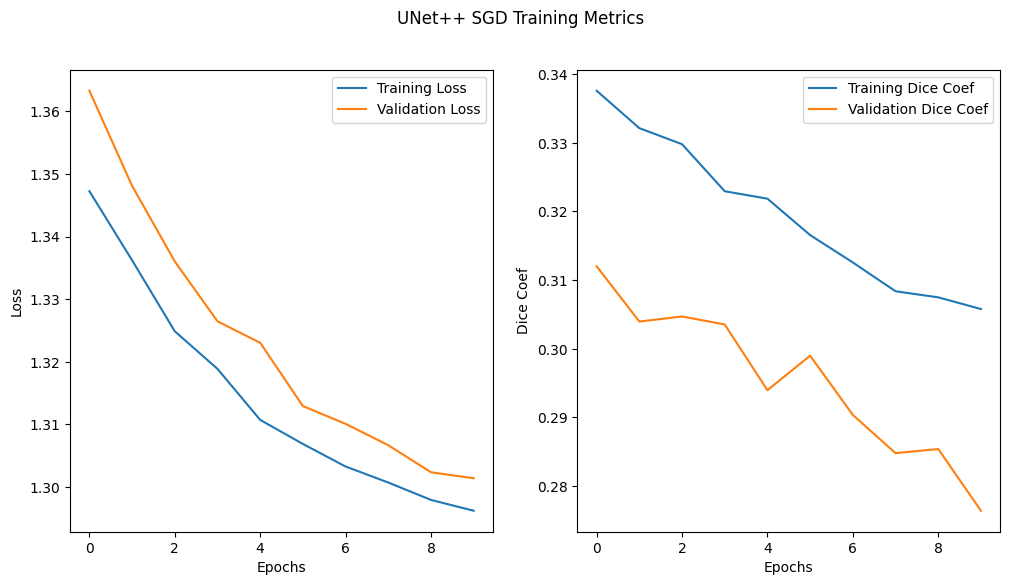

In [17]:
if "UNET_ADAM" in MODELS_TO_RUN:
    graph_loss_dice("UNet Adam", unet_history_adam)
if "UNET_SGD" in MODELS_TO_RUN:
    graph_loss_dice("UNet SGD", unet_history_sgd)
if "UNET++_ADAM" in MODELS_TO_RUN:
    graph_loss_dice("UNet++ Adam", unet_plus_history_adam)
if "UNET++_SGD" in MODELS_TO_RUN:
    graph_loss_dice("UNet++ SGD", unet_plus_history_sgd)

# DICE obtenido por cada modelo

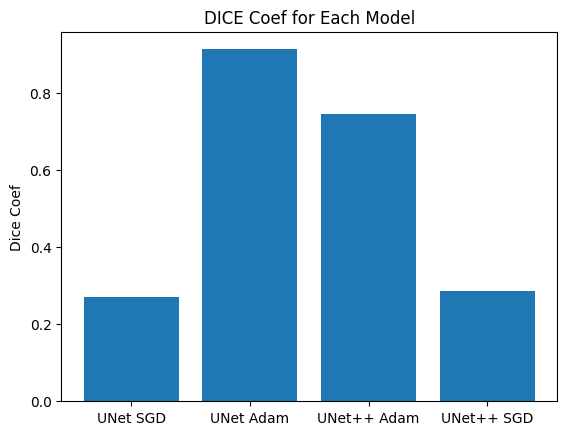

DICE Coef for UNet Adam: 0.9137259721755981
DICE Coef for UNet SGD: 0.27156782150268555
DICE Coef for UNet++ Adam: 0.7444910407066345
DICE Coef for UNet++ SGD: 0.2862011194229126


In [18]:
if "UNET_ADAM" in MODELS_TO_RUN:
    dice_unet_adam = eval_unet_adam[1]
if "UNET_SGD" in MODELS_TO_RUN:
    dice_unet_sgd = eval_unet_sgd[1]
if "UNET++_ADAM" in MODELS_TO_RUN:
    dice_unet_plus_adam = eval_unet_plus_adam[1]
if "UNET++_SGD" in MODELS_TO_RUN:
    dice_unet_plus_sgd = eval_unet_plus_sgd[1]

x = []
y = []
for model in MODELS_TO_RUN:
    if model == "UNET_ADAM":
        x.append("UNet Adam")
        y.append(dice_unet_adam)
    elif model == "UNET_SGD":
        x.append("UNet SGD")
        y.append(dice_unet_sgd)
    elif model == "UNET++_ADAM":
        x.append("UNet++ Adam")
        y.append(dice_unet_plus_adam)
    elif model == "UNET++_SGD":
        x.append("UNet++ SGD")
        y.append(dice_unet_plus_sgd)


plt.bar(x, y)
plt.ylabel("Dice Coef")
plt.title("DICE Coef for Each Model")
plt.show()

if "UNET_ADAM" in MODELS_TO_RUN:
    print(f"DICE Coef for UNet Adam: {dice_unet_adam}")
if "UNET_SGD" in MODELS_TO_RUN:
    print(f"DICE Coef for UNet SGD: {dice_unet_sgd}")
if "UNET++_ADAM" in MODELS_TO_RUN:
    print(f"DICE Coef for UNet++ Adam: {dice_unet_plus_adam}")
if "UNET++_SGD" in MODELS_TO_RUN:
    print(f"DICE Coef for UNet++ SGD: {dice_unet_plus_sgd}")

# Ejemplos de casos dificiles y faciles

## Funcion para visualizar casos dificiles y faciles

In [19]:
def generate_masked_image(xray_image, true_mask, pred_mask):
    # Original X-ray image
    xray_image = np.squeeze(xray_image) * 255
    xray_image = xray_image.astype(np.uint8)

    # True mask
    true_mask = np.squeeze(true_mask) * 255
    true_mask_binary = (true_mask > 127).astype(np.uint8)

    # Predicted mask
    pred_mask = np.squeeze(pred_mask) * 255
    pred_mask_binary = (pred_mask > 127).astype(np.uint8)

    # Overlapping mask (yellow)
    overlap_mask = true_mask_binary & pred_mask_binary

    # Create an RGB image for overlay
    masked_image = np.stack((xray_image,) * 3, axis=-1)

    # Overlay the true mask in green
    masked_image[true_mask_binary == 1] = [0, 255, 0]

    # Overlay the predicted mask in red, avoiding overlap
    masked_image[(pred_mask_binary == 1) & (overlap_mask == 0)] = [255, 0, 0]

    # Overlay the overlapping area in yellow
    masked_image[overlap_mask == 1] = [255, 255, 0]

    return masked_image

In [20]:
def calculate_dice_scores(true_masks, pred_masks):
    # Calculate Dice scores for a batch of true and predicted masks
    dice_scores = np.array([2 * np.sum(p * t) / (np.sum(p) + np.sum(t) + 1e-6) for p, t in zip(pred_masks, true_masks)])
    return dice_scores


def group_and_visualize_results(model, test_data, num_images=9):
    test_images, test_masks = next(test_data)
    pred_masks = model.predict(test_images)

    # Convert masks to binary format
    true_masks_binary = (test_masks > 0.5).astype(np.uint8)
    pred_masks_binary = (pred_masks > 0.5).astype(np.uint8)

    # Calculate Dice scores
    dice_scores = calculate_dice_scores(true_masks_binary, pred_masks_binary)

    # Sort the images by Dice score
    sorted_indices = np.argsort(dice_scores)
    best_indices = sorted_indices[-3:]  # Last three with highest Dice scores
    worst_indices = sorted_indices[:3]  # First three with lowest Dice scores
    middle_indices = sorted_indices[num_images // 2 - 1 : num_images // 2 + 2]  # Three middle scores

    # Helper function to plot images and masks
    def plot_group(indices, group_name):
        group_dice_scores = dice_scores[indices]
        avg_dice_score = np.mean(group_dice_scores)
        plt.figure(figsize=(15, 10))
        plt.suptitle(f"{group_name} (Dice={avg_dice_score:.3f})", fontsize=16)

        for i, idx in enumerate(indices, 1):
            # Original X-ray image
            plt.subplot(2, 3, i)
            xray_image = np.squeeze(test_images[idx]) * 255
            plt.imshow(xray_image.astype(np.uint8), cmap="gray")
            plt.axis("off")

            # Overlay masks
            plt.subplot(2, 3, i + 3)
            masked_image = generate_masked_image(test_images[idx], test_masks[idx], pred_masks[idx])
            plt.imshow(masked_image)
            plt.axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust as needed
        plt.show()

    # Plot groups
    plot_group(best_indices, "Best")
    plot_group(middle_indices, "Average")
    plot_group(worst_indices, "Worst")

## Modelo UNet Adam

1/1 [==============================] - 0s 264ms/step


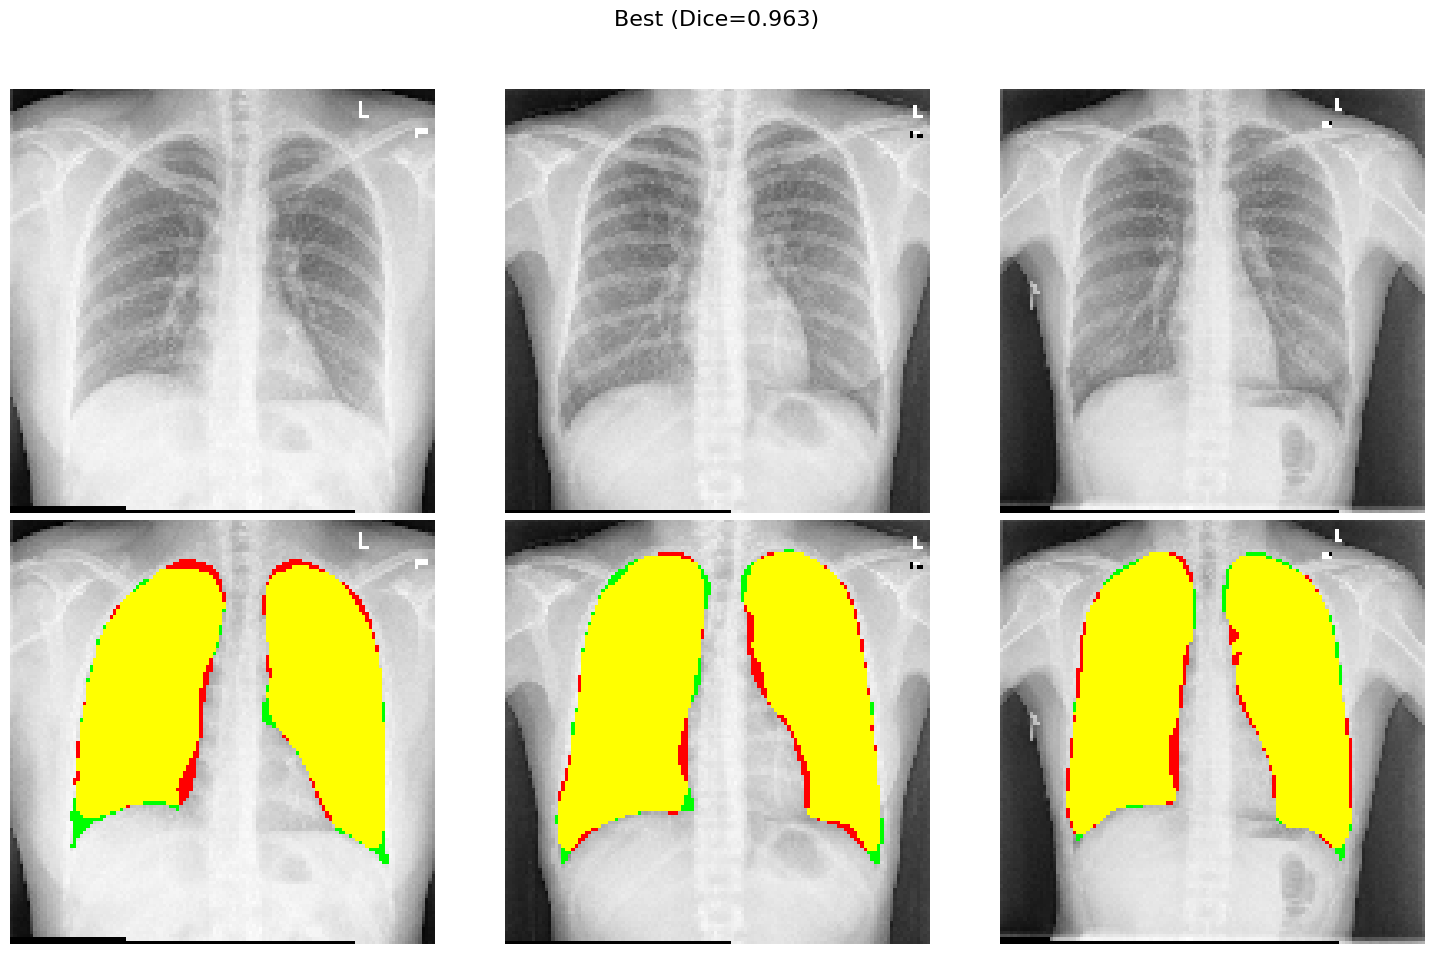

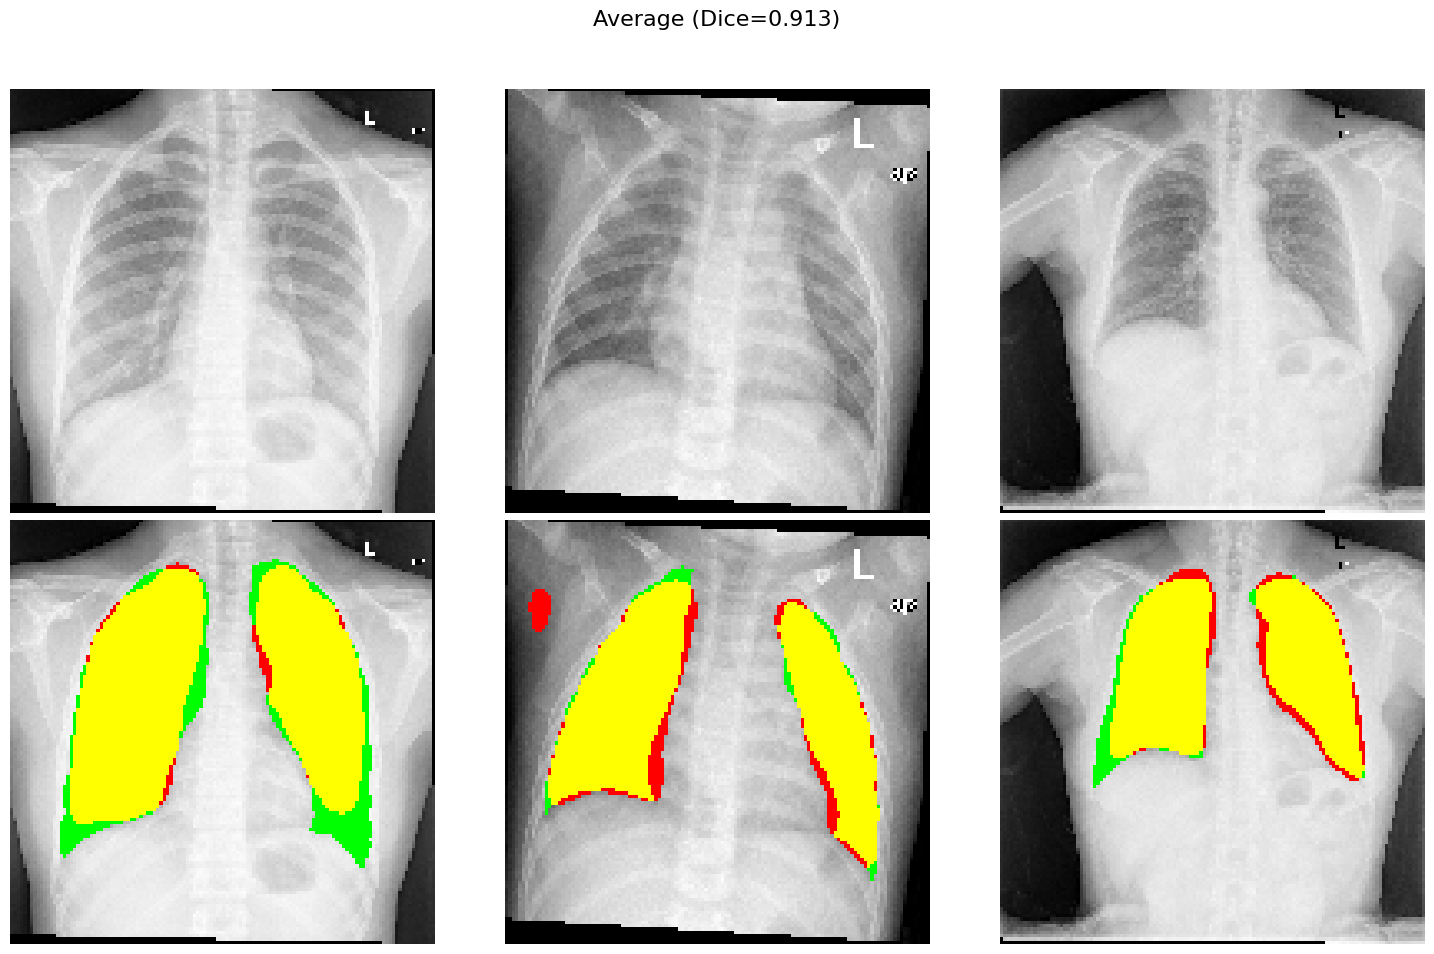

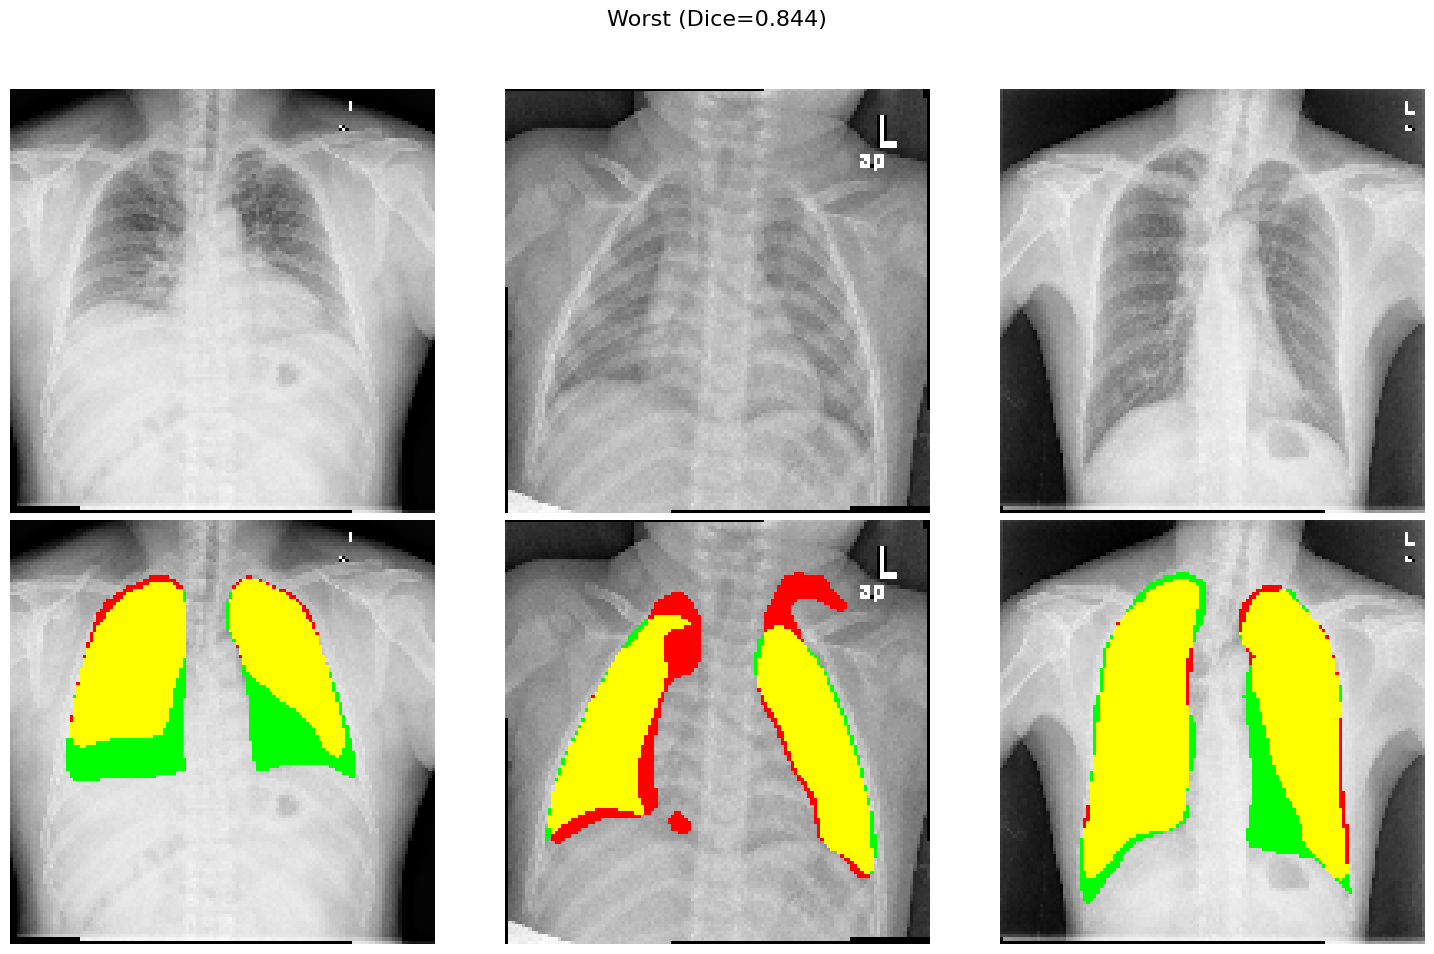

In [21]:
if "UNET_ADAM" in MODELS_TO_RUN:
    group_and_visualize_results(unet_adam, eval_datagen)

## Modelo UNet SGD

1/1 [==============================] - 0s 228ms/step


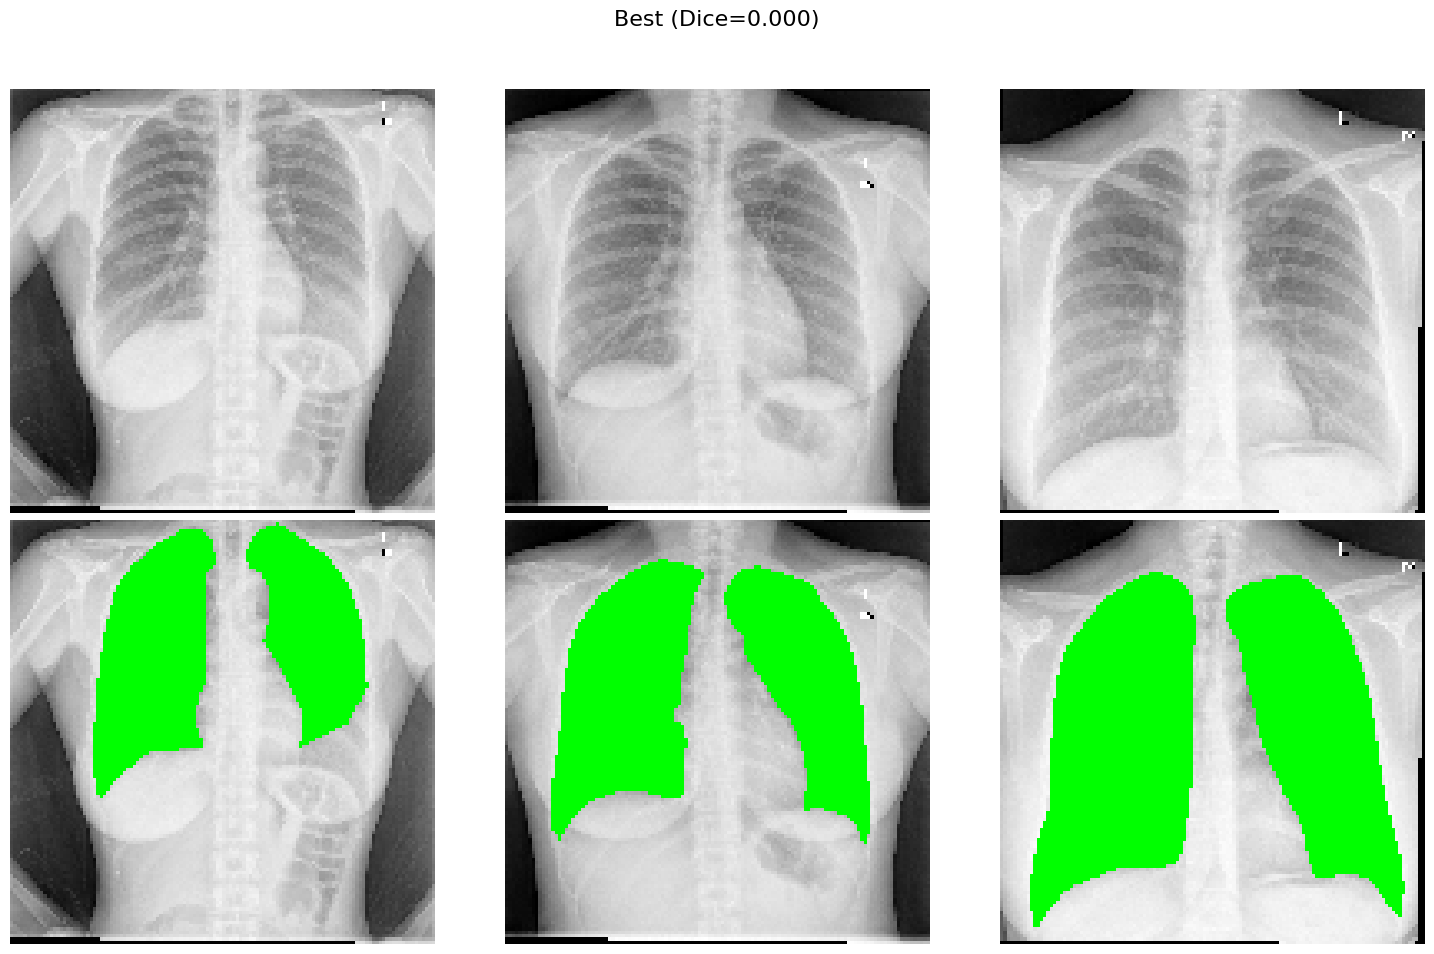

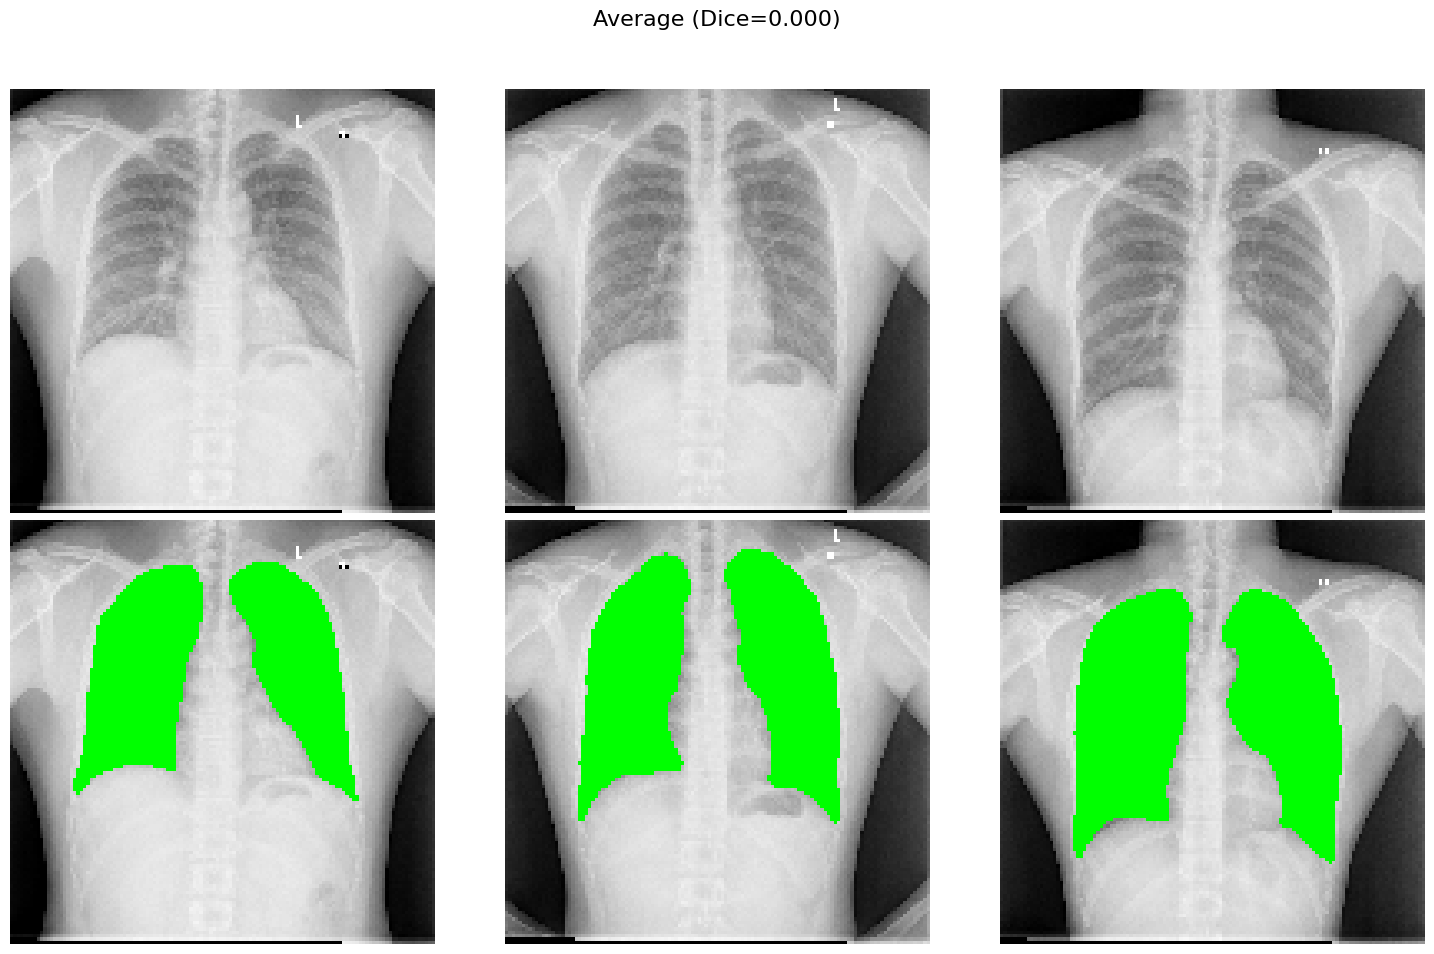

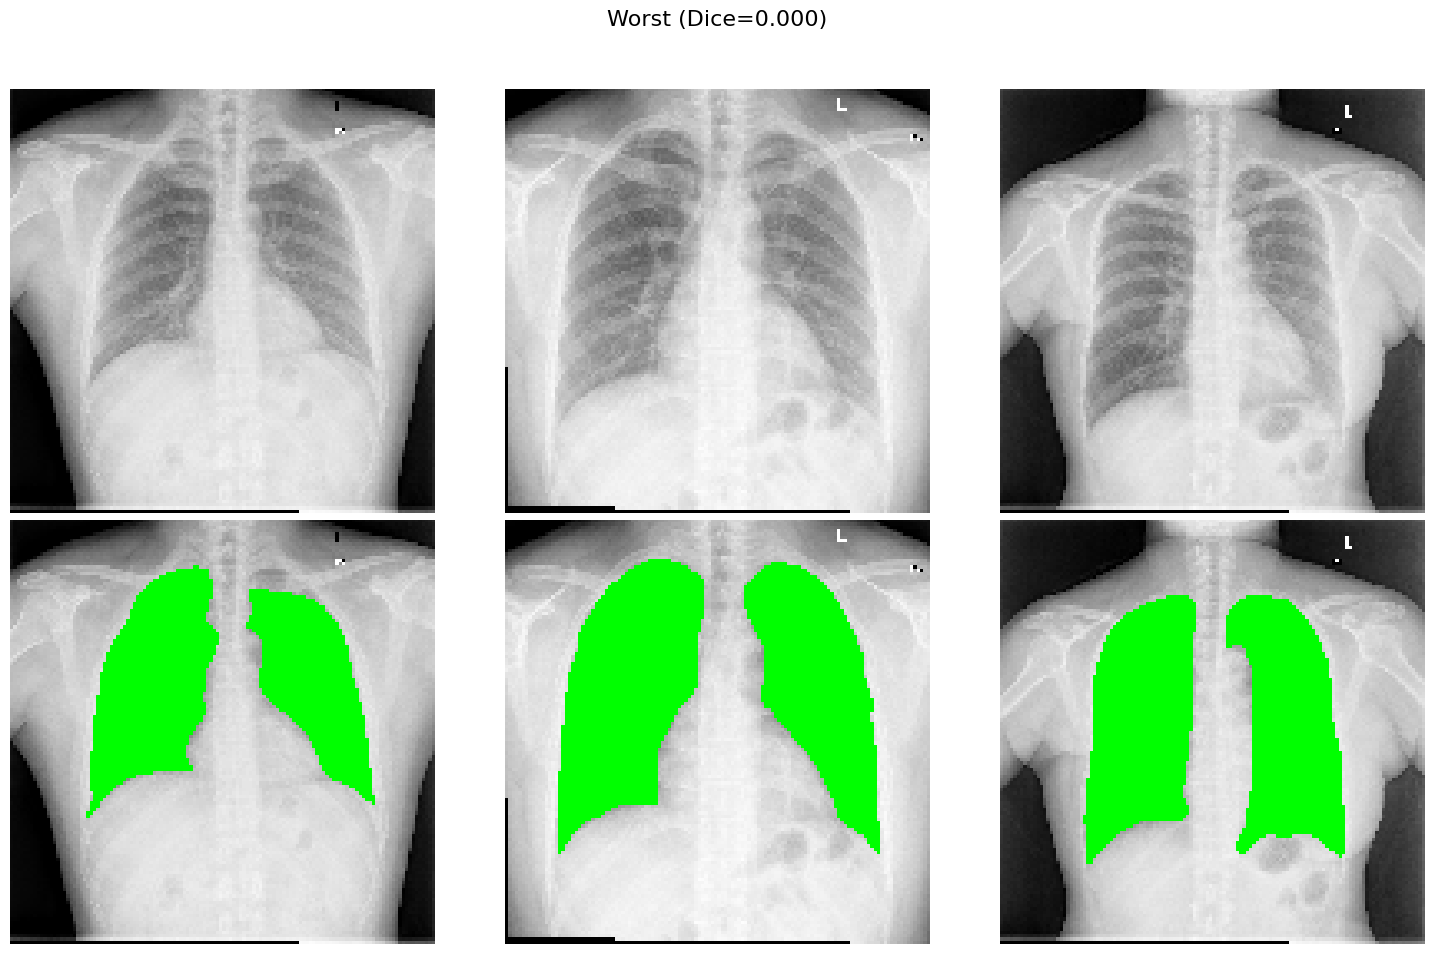

In [22]:
if "UNET_SGD" in MODELS_TO_RUN:
    group_and_visualize_results(unet_sgd, eval_datagen)

## Modelo UNet++ Adam

1/1 [==============================] - 0s 207ms/step


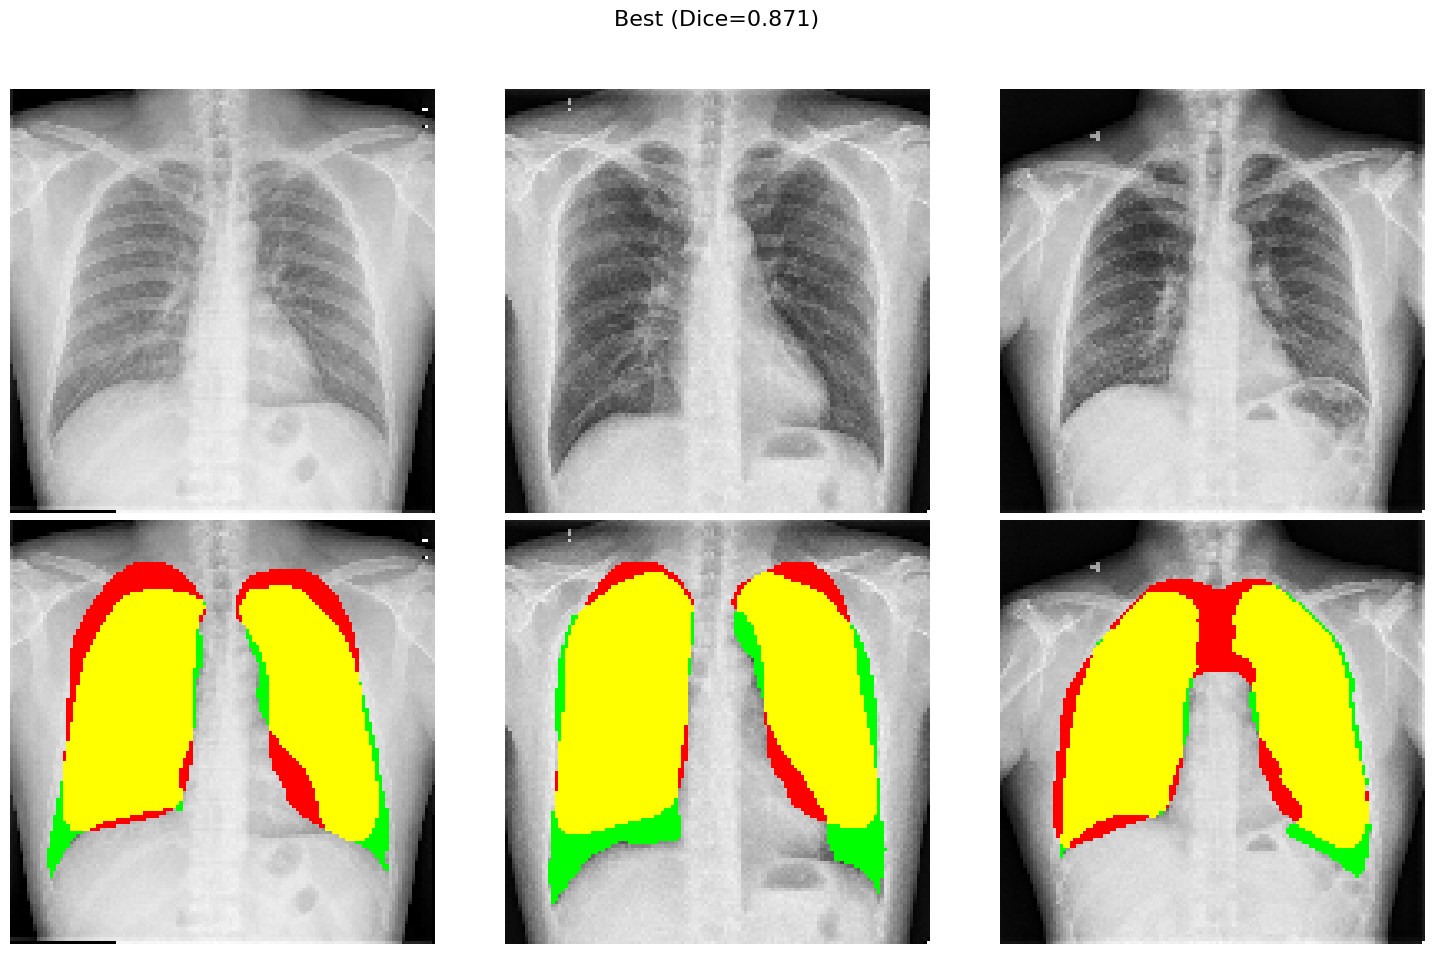

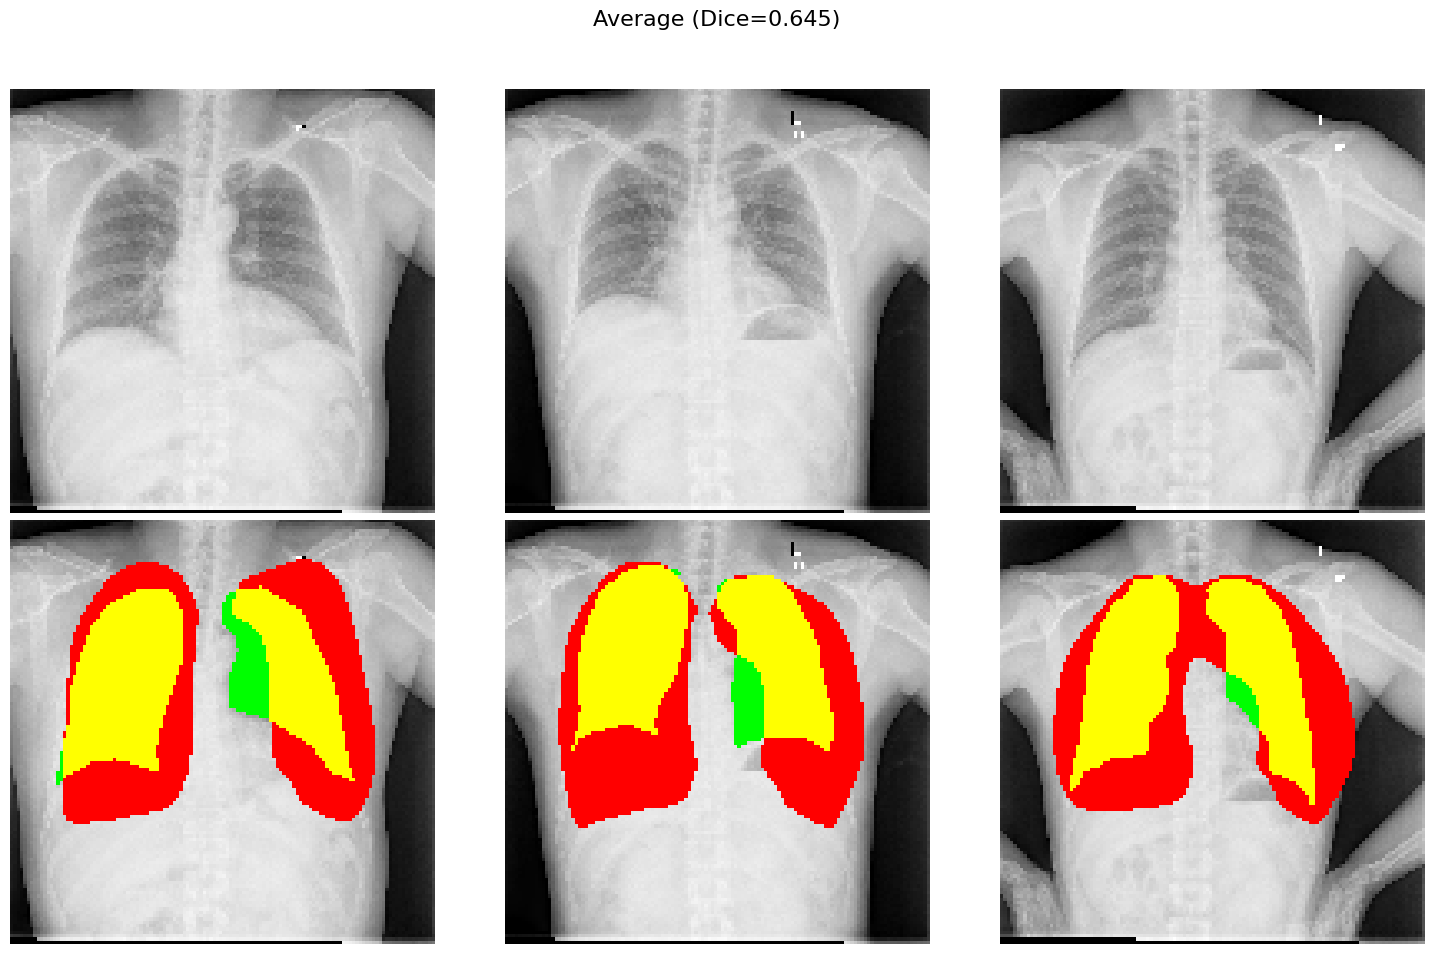

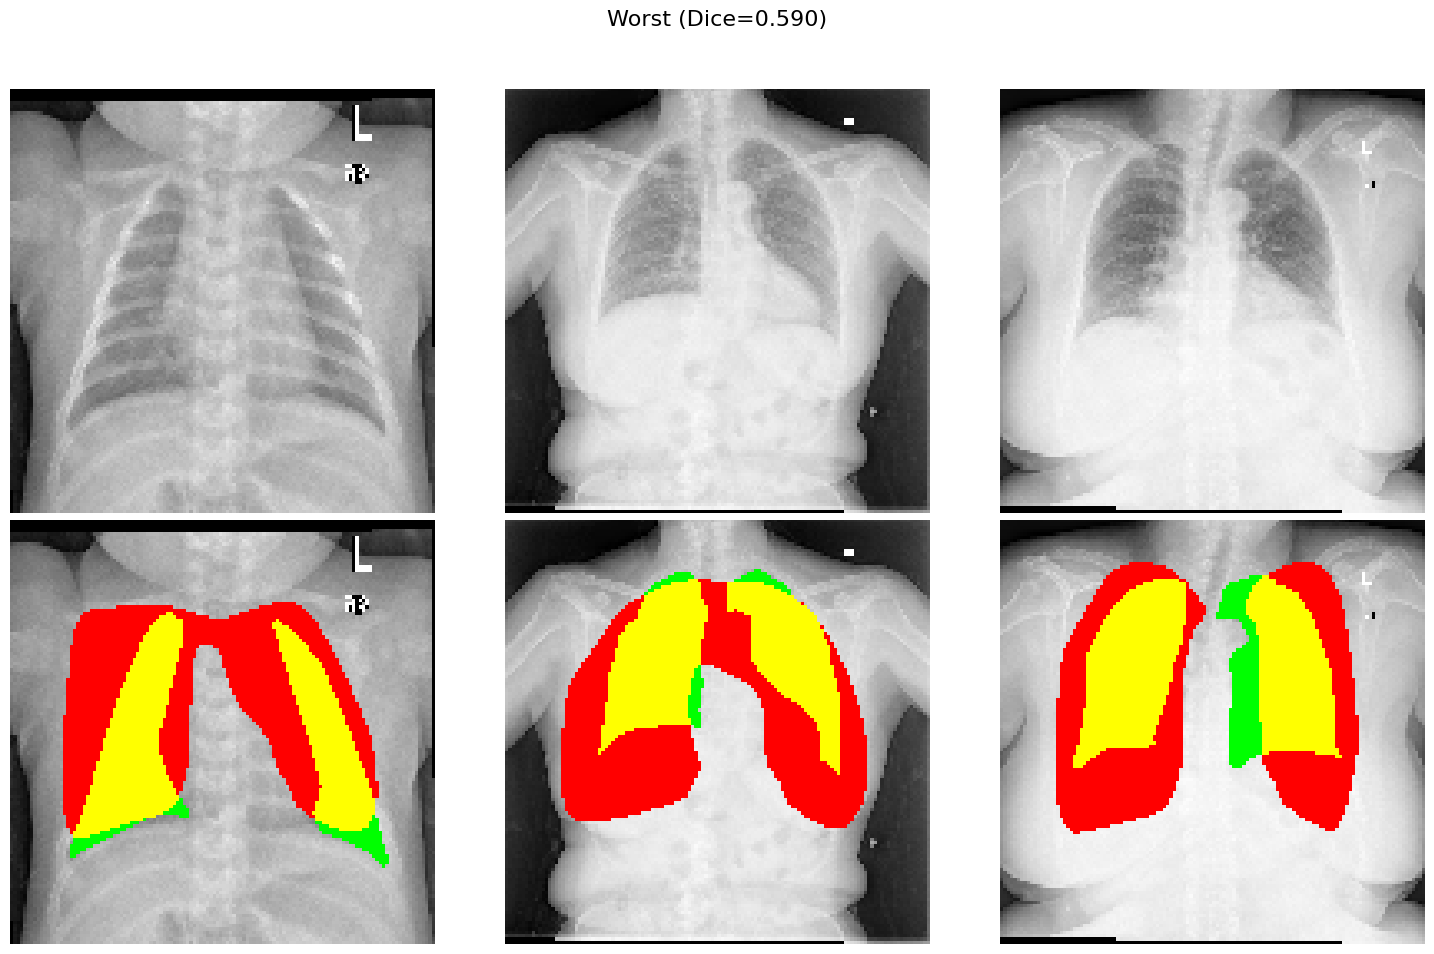

In [23]:
if "UNET++_ADAM" in MODELS_TO_RUN:
    group_and_visualize_results(unet_plus_adam, eval_datagen)

## Modelo UNet++ SGD

1/1 [==============================] - 0s 201ms/step


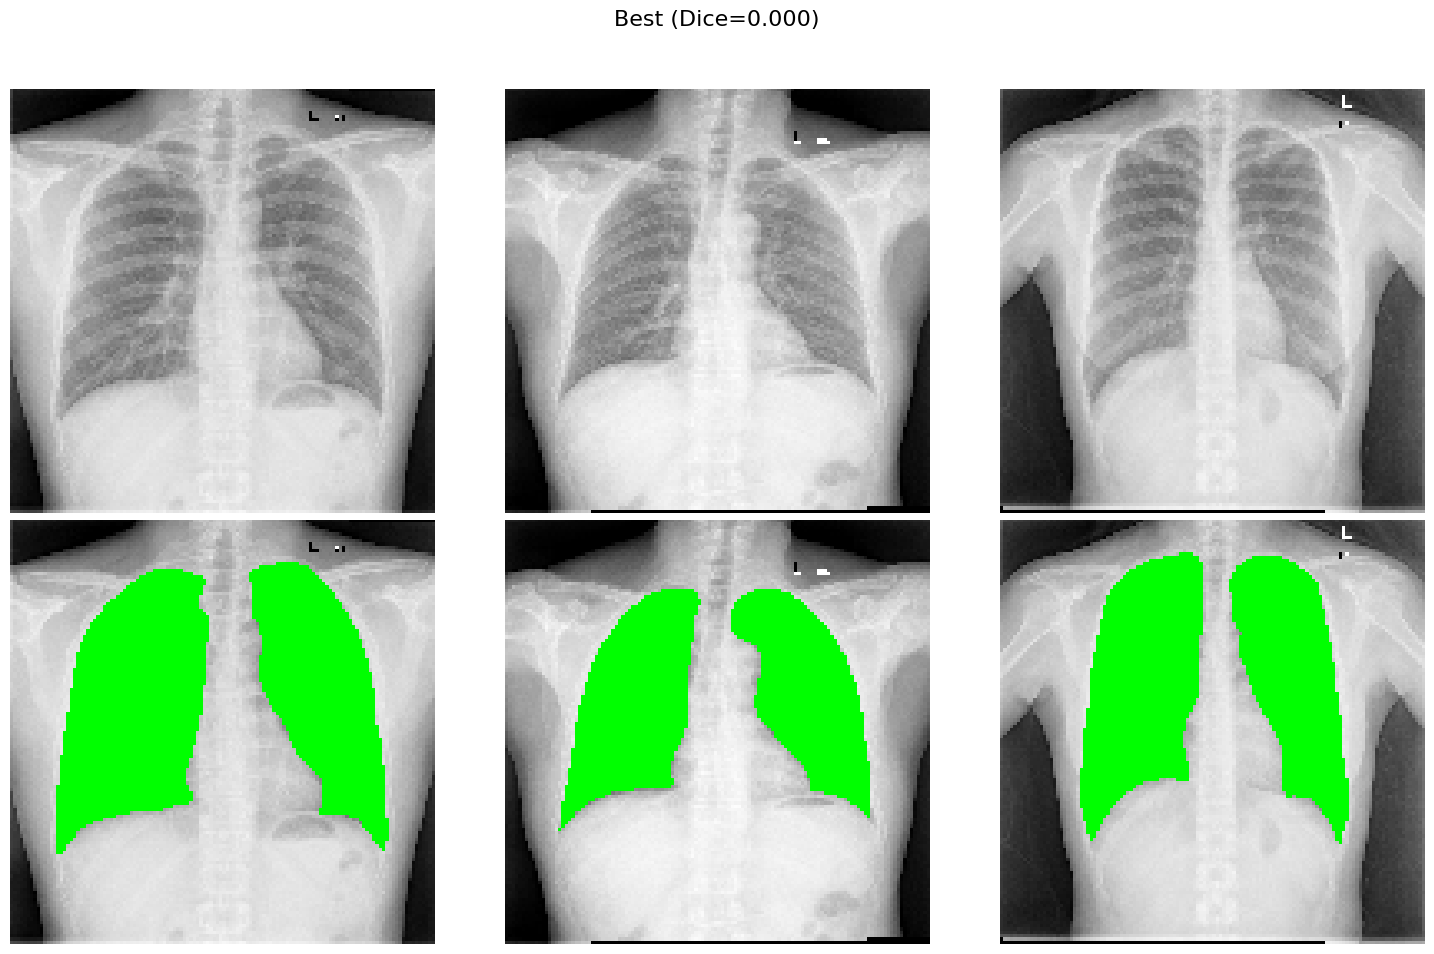

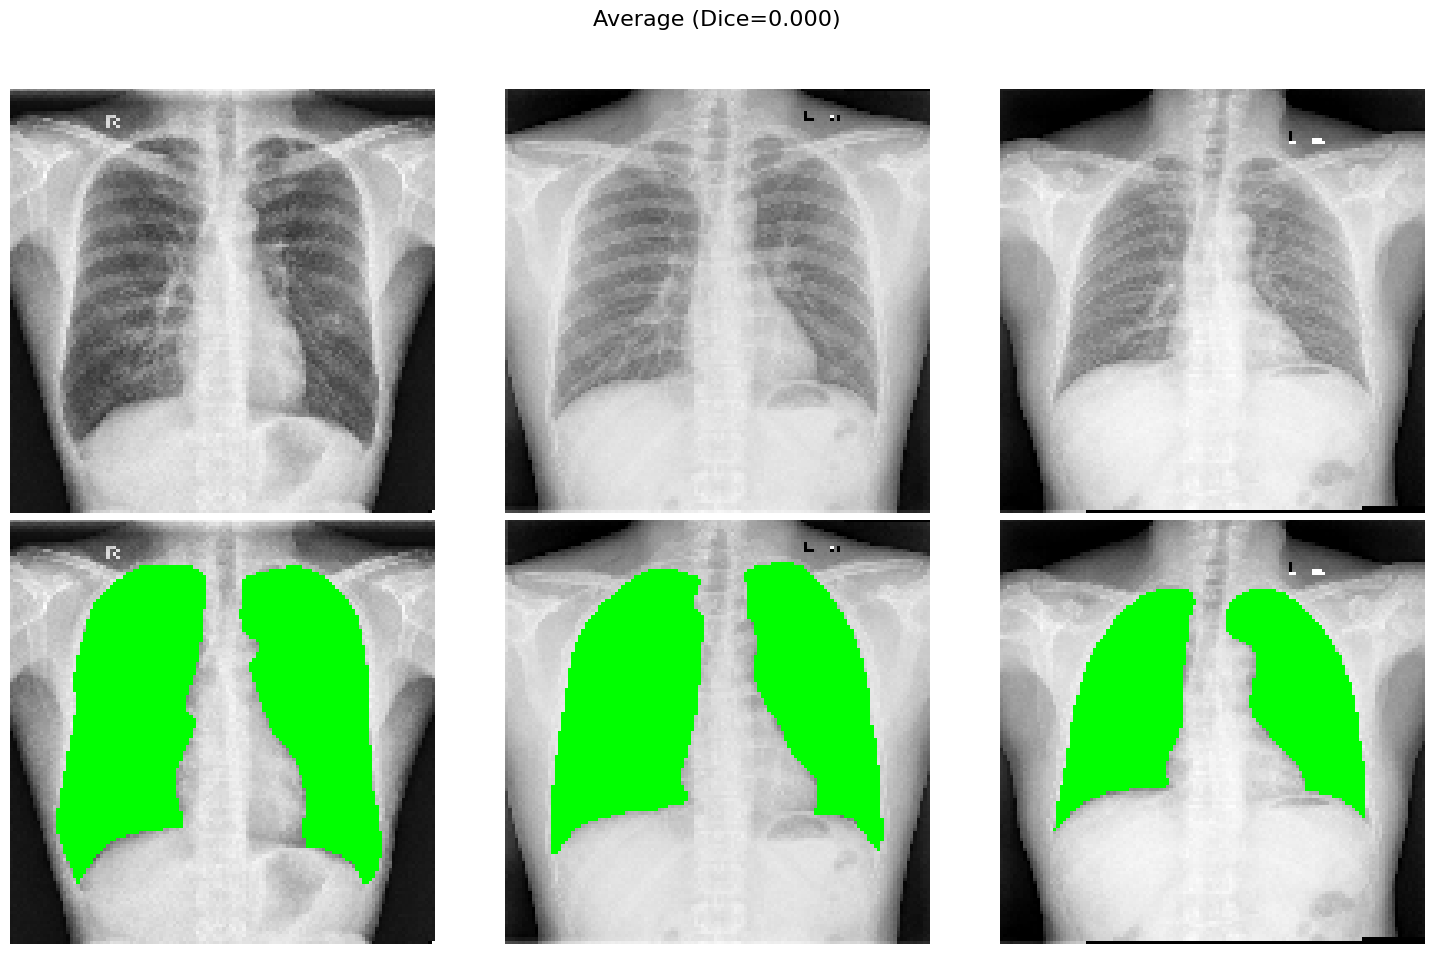

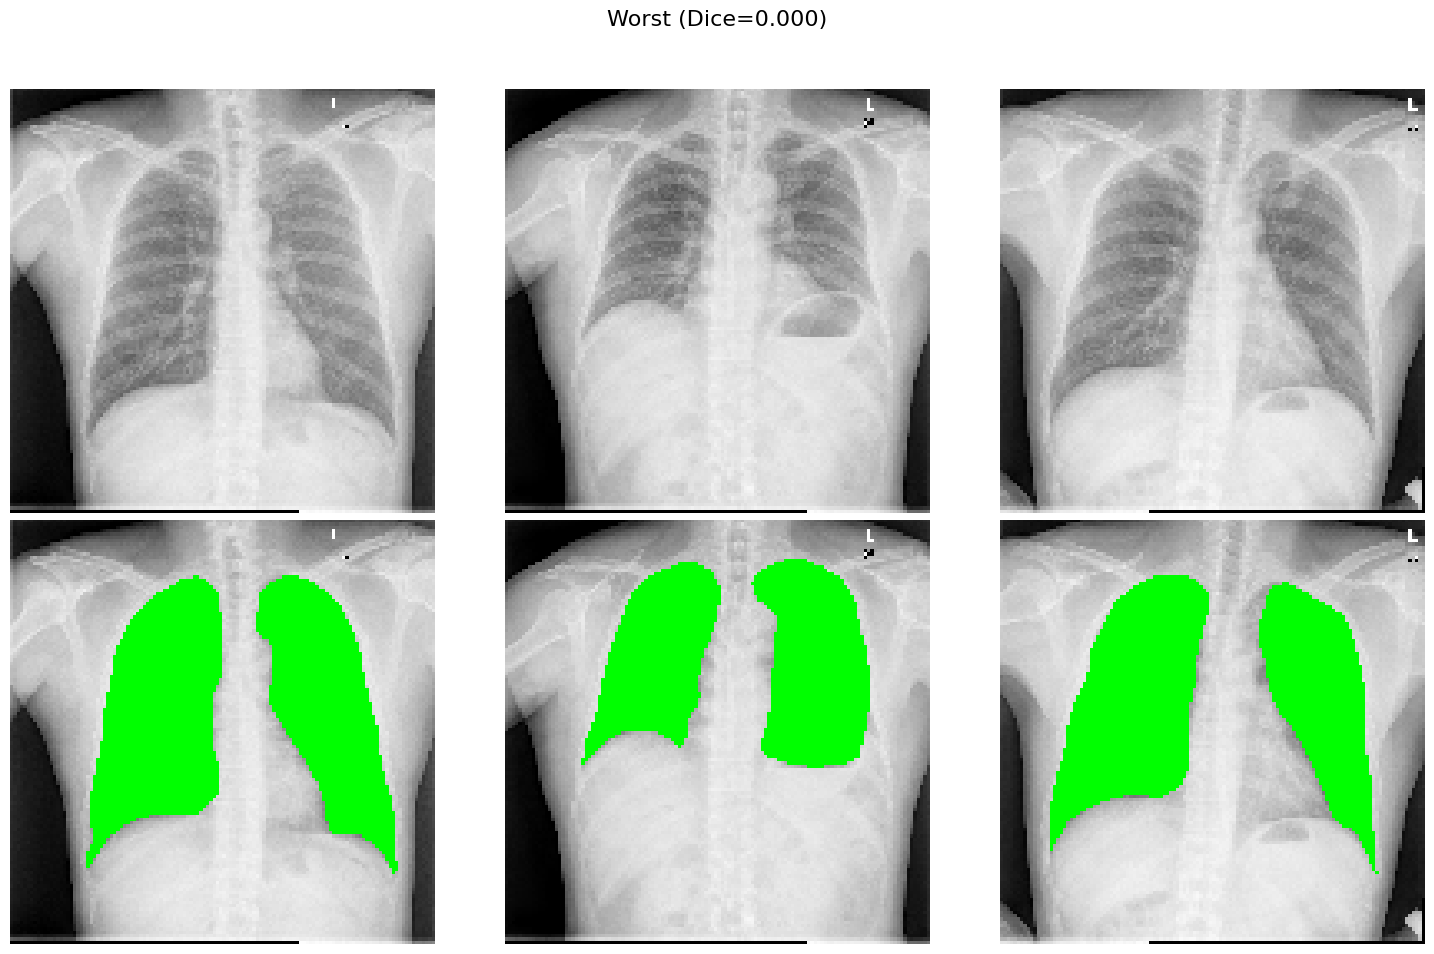

In [24]:
if "UNET++_SGD" in MODELS_TO_RUN:
    group_and_visualize_results(unet_plus_sgd, eval_datagen)